In [34]:
%matplotlib inline

import os
import sys
import math
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from functools import partial

module_path = os.path.abspath(os.path.join('..'))
src_path = '{}/src'.format(module_path)
if module_path not in sys.path:
    sys.path.append(src_path)
    
from preprocessing import select

### Primeiro precisamos definir os tamanhos de cada campo

In [35]:
widths = [
    # Identificação de controle.
    2, 8, 7, 4, 9, 1,

    # Módulo C - Características gerais dos moradores.
    2, 2, 2, 1, 2, 2, 4, 3, 1, 1, 1, 1,

    # Módulo D - Características de educação das pessoas de 5 anos ou mais de
    # idade.
    1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,

    # Módulo E - Trabalho dos moradores do domicílio.
    1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 4, 1, 5, 1, 8, 1, 8, 1, 3, 1, 8, 1, 8,
    1, 3, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,

    # Módulo F - Rendimentos domiciliares.
    1, 8, 1, 8, 1, 8, 1, 8, 

    # Módulo G - Pessoas com deficiências.
    1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
    1, 1, 1, 1,

    # Módulo I - Cobertura de plano de saúde.
    1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,

    # Módulo J - Utilização de serviços de saúde.
    1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
    1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    # Módulo K - Saúdes dos indivíduos com 60 anos ou mais e cobertura de
    # mamografia entre mulheres de 50 anos ou mais.
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1,

    # Módulo L - Crianças com menos de 2 anos.
    2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 2, 2, 4, 2, 2, 4,
    2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    # Módulo M - Informações para futuros contatos,  características do trabalho
    # e apoio social.
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
    1,

    # Módulo N - Percepção do estado de saúde.
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    # Módulo O - Acidentes e violências.
    1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,

    # Módulo P - Estilos de vida.
    1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
    1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2,
    1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 9, 1, 2, 2, 2, 2,
    2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    # Módulo Q - Doenças crônicas.
    1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
    2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
    1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
    1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
    1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,

    # Módulo R - Saúde da mulher (mulheres de 18 anos ou mais de idade).
    1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
    1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
    1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,

    # Módulo S - Atendimento pré-natal.
    1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
    1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

    # Módulo U - Saúde bucal.
    1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,

    # Módulo X - Atendimento médico.
    1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

    # Módulo W - Informações laboratoriais.
    5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 5, 5,

    # Variáveis de amostragem.
    14, 14, 14, 14, 9, 17, 3, 5,

    # Variáveis derivadas de morador.
    1, 1, 1, 8
]

### Também precisamos definir os nomes referentes a cada campo

In [36]:
names = [
    # Identificação de controle.
    'V0001', 'V0024', 'UPA_PNS', 'V0006_PNS', 'UPA', 'V0025',

    # Módulo C - Características gerais dos moradores.
    'C001', 'C00301', 'C004', 'C006', 'C00701', 'C00702', 'C00703', 'C008',
    'C009', 'C010', 'C011', 'C012',

    # Módulo D - Características de educação das pessoas de 5 anos ou mais de
    # idade.
    'D001', 'D002', 'D003', 'D004', 'D005', 'D006', 'D007', 'D008', 'D009',
    'D010', 'D011', 'D012', 'D013', 'D014', 'D015',

    # Módulo E - Trabalho dos moradores do domicílio.
    'E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008', 'E01001',
    'E01002', 'E01003', 'E011', 'E01201', 'E014', 'E01501', 'E01601', 'E01602',
    'E01603', 'E01604', 'E01605', 'E017', 'E01801', 'E01802', 'E01803',
    'E01804', 'E01805', 'E019', 'E020', 'E021', 'E022', 'E023', 'E024', 'E025',
    'E02501', 'E02502', 'E026', 'E027',

    # Módulo F - Rendimentos domiciliares.
    'F001', 'F00102', 'F007', 'F00702', 'F008', 'F00802', 'VDF001',
    'VDF00102',

    # Módulo G - Pessoas com deficiências.
    'G001', 'G002', 'G00201', 'G003', 'G004', 'G005', 'G006', 'G007', 'G00701',
    'G008', 'G009', 'G010', 'G014', 'G015', 'G01501', 'G016', 'G017', 'G018',
    'G021', 'G022', 'G02201', 'G023', 'G024', 'G02501', 'G02502', 'G02503',
    'G026', 'G027', 'G032',

    # Módulo I - Cobertura de plano de saúde.
    'I001', 'I002', 'I003', 'I004', 'I005', 'I006', 'I007', 'I00701', 'I008',
    'I009', 'I010', 'I011',

    # Módulo J - Utilização de serviços de saúde.
    'J001', 'J002', 'J003', 'J004', 'J005', 'J006', 'J007', 'J008', 'J009',
    'J010', 'J011', 'J012', 'J013', 'J014', 'J015', 'J016', 'J017', 'J018',
    'J019', 'J020', 'J021', 'J022', 'J023', 'J024', 'J025', 'J026', 'J027',
    'J029', 'J030', 'J031', 'J032', 'J033', 'J034', 'J035', 'J036', 'J037',
    'J038', 'J039', 'J04001', 'J04002', 'J041', 'J042', 'J043', 'J044', 'J045',
    'J046', 'J047', 'J048', 'J049', 'J050', 'J051', 'J052', 'J053', 'J054',
    'J055', 'J056', 'J057', 'J058', 'J059', 'J060',

    # Módulo K - Saúdes dos indivíduos com 60 anos ou mais e cobertura de
    # mamografia entre mulheres de 50 anos ou mais.
    'K001', 'K002', 'K003', 'K004', 'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014', 'K015', 'K016', 'K017', 'K018',
    'K019', 'K020', 'K021', 'K022', 'K023', 'K024', 'K025', 'K026', 'K027',
    'K028', 'K029', 'K030', 'K031', 'K032', 'K033', 'K034', 'K035', 'K036',
    'K039', 'K040', 'K041', 'K042', 'K043', 'K044', 'K045', 'K046', 'K047',
    'K048', 'K049', 'K050', 'K051', 'K052', 'K053', 'K054', 'K055', 'K056',
    'K057', 'K058', 'K059', 'K06001', 'K06002', 'K06003', 'K06101', 'K06102',
    'K062',

    # Módulo L - Crianças com menos de 2 anos.
    'L00201', 'L00202', 'L00203', 'L003', 'L004', 'L005', 'L006', 'L007',
    'L008', 'L009', 'L010', 'L011', 'L012', 'L013', 'L014', 'L015', 'L01613',
    'L01614', 'L01615', 'L01616', 'L01617', 'L01618', 'L01619', 'L01620',
    'L01621', 'L01622', 'L01623', 'L01624', 'L01701', 'L01702', 'L01703',
    'L01704', 'L01705', 'L01706', 'L01707', 'L01708', 'L01709', 'L01710',
    'L01711', 'L01712', 'L01713', 'L01714', 'L01715', 'L01716', 'L018', 'L019',
    'L020',

    # Módulo M - Informações para futuros contatos,  características do trabalho
    # e apoio social.
    'M001', 'M002', 'M003', 'M005', 'M006', 'M007', 'M008', 'M009', 'M010',
    'M01101', 'M01102', 'M01103', 'M01104', 'M01105', 'M01106', 'M01107',
    'M01108', 'M01301', 'M01302', 'M01303', 'M014', 'M015', 'M016', 'M017',
    'M018', 'M019',

    # Módulo N - Percepção do estado de saúde.
    'N001', 'N002', 'N003', 'N004', 'N005', 'N006', 'N007', 'N008', 'N010',
    'N011', 'N012', 'N013', 'N014', 'N015', 'N016', 'N017', 'N018', 'N019',
    'N020', 'N021', 'N022', 'N023',

    # Módulo O - Acidentes e violências.
    'O001', 'O002', 'O003', 'O004', 'O005', 'O006', 'O007', 'O008', 'O009',
    'O00901', 'O010', 'O011', 'O012', 'O013', 'O014', 'O015', 'O016', 'O017',
    'O01801', 'O01802', 'O019', 'O020', 'O021', 'O02101', 'O022', 'O023',
    'O024', 'O025', 'O027', 'O028', 'O029', 'O030', 'O031', 'O032', 'O033',
    'O034', 'O035', 'O036', 'O037', 'O038', 'O039', 'O040', 'O041', 'O042',
    'O043', 'O044', 'O045', 'O046', 'O047', 'O048',

    # Módulo P - Estilos de vida.
    'P001', 'P00101', 'P002', 'P003', 'P00301', 'P004', 'P00401',
    'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012',
    'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020',
    'P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P02601', 'P027',
    'P028', 'P029', 'P030', 'P031', 'P032', 'P033', 'P034', 'P035',
    'P036', 'P03701', 'P03702', 'P038', 'P039', 'P03901', 'P03902',
    'P03903', 'P040', 'P04101', 'P04102', 'P042', 'P04301', 'P04302',
    'P044', 'P04401', 'P04403', 'P04404', 'P045', 'P046', 'P047',
    'P048', 'P049', 'P050', 'P051', 'P052', 'P053', 'P05401', 'P05402',
    'P05403', 'P05404', 'P05405', 'P05406', 'P05407', 'P05408',
    'P05409', 'P05410', 'P05411', 'P05412', 'P05413', 'P05414',
    'P05415', 'P05416', 'P05417', 'P05418', 'P05419', 'P05421',
    'P05422', 'P055', 'P056', 'P05601', 'P05602', 'P05603', 'P05604',
    'P05605', 'P057', 'P058', 'P05801', 'P05802', 'P05901', 'P05902',
    'P05903', 'P05904', 'P060', 'P061', 'P062', 'P063', 'P064', 'P065',
    'P066', 'P067', 'P068', 'P069', 'P07001', 'P07002', 'P07003',
    'P071', 'P072',

    # Módulo Q - Doenças crônicas.
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
    'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q01801',
    'Q01802', 'Q01803', 'Q01804', 'Q01805', 'Q01806', 'Q01807', 'Q01808',
    'Q01901', 'Q01902', 'Q01903', 'Q01904', 'Q01905', 'Q020', 'Q021', 'Q022',
    'Q023', 'Q024', 'Q026', 'Q027', 'Q028', 'Q029', 'Q030', 'Q031', 'Q032',
    'Q033', 'Q03401', 'Q03402', 'Q035', 'Q036', 'Q037', 'Q038', 'Q039', 'Q040',
    'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q04601', 'Q04602', 'Q04603',
    'Q04604', 'Q04605', 'Q04606', 'Q04607', 'Q04608', 'Q04609', 'Q04701',
    'Q04702', 'Q04703', 'Q04704', 'Q04705', 'Q048', 'Q049', 'Q050', 'Q051',
    'Q052', 'Q053', 'Q054', 'Q05501', 'Q05502', 'Q05503', 'Q05504', 'Q05505',
    'Q05506', 'Q05507', 'Q05508', 'Q05509', 'Q056', 'Q057', 'Q058', 'Q059',
    'Q060', 'Q061', 'Q06201', 'Q06202', 'Q06203', 'Q06204', 'Q06205', 'Q06206',
    'Q063', 'Q06301', 'Q06302', 'Q06303', 'Q06304', 'Q064', 'Q06501', 'Q06502',
    'Q06503', 'Q06504', 'Q066', 'Q067', 'Q068', 'Q069', 'Q070', 'Q071',
    'Q07201', 'Q07202', 'Q07203', 'Q07204', 'Q07205', 'Q07206', 'Q073', 'Q074',
    'Q075', 'Q076', 'Q07701', 'Q07702', 'Q078', 'Q079', 'Q080', 'Q08101',
    'Q08102', 'Q08103', 'Q08104', 'Q08105', 'Q082', 'Q083', 'Q084', 'Q085',
    'Q08601', 'Q08603', 'Q08604', 'Q08605', 'Q087', 'Q088', 'Q089', 'Q09001',
    'Q09003', 'Q09004', 'Q09005', 'Q091', 'Q092', 'Q093', 'Q094', 'Q095',
    'Q09601', 'Q09602', 'Q09603', 'Q097', 'Q098', 'Q100', 'Q101', 'Q102',
    'Q103', 'Q104', 'Q105', 'Q106', 'Q107', 'Q108', 'Q109', 'Q110', 'Q11001',
    'Q11002', 'Q11003', 'Q11004', 'Q111', 'Q112', 'Q113', 'Q11401', 'Q11402',
    'Q11403', 'Q115', 'Q116', 'Q11601', 'Q11602', 'Q11603', 'Q117', 'Q11801',
    'Q11802', 'Q11803', 'Q11804', 'Q119', 'Q120', 'Q121', 'Q122', 'Q123',
    'Q124', 'Q125', 'Q12601', 'Q12602', 'Q12603', 'Q12604', 'Q12605', 'Q127',
    'Q128', 'Q130', 'Q131', 'Q132', 'Q133', 'Q134', 'Q135', 'Q136', 'Q137',

    # Módulo R - Saúde da mulher (mulheres de 18 anos ou mais de idade).
    'R001', 'R002', 'R003', 'R004', 'R005', 'R006', 'R007', 'R008', 'R009',
    'R010', 'R011', 'R012', 'R013', 'R014', 'R015', 'R016', 'R017', 'R018',
    'R019', 'R020', 'R021', 'R022', 'R023', 'R024', 'R025', 'R026', 'R027',
    'R028', 'R029', 'R030', 'R031', 'R032', 'R033', 'R034', 'R035', 'R03601',
    'R03602', 'R03603', 'R03604', 'R03605', 'R03606', 'R03607', 'R03608',
    'R03609', 'R03610', 'R03611', 'R037', 'R038', 'R039', 'R040', 'R041',
    'R04101', 'R042', 'R04201', 'R043', 'R044', 'R045', 'R046', 'R047', 'R048',
    'R04901', 'R04902', 'R04903',

    # Módulo S - Atendimento pré-natal.
    'S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009',
    'S01001', 'S01002', 'S01003', 'S01004', 'S01005', 'S01101', 'S01102',
    'S01103', 'S012', 'S013', 'S01401', 'S01402', 'S01403', 'S01404', 'S01405',
    'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023',
    'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032',
    'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041',
    'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050',
    'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058',

    # Módulo U - Saúde bucal.
    'U001', 'U00201', 'U00202', 'U00203', 'U004', 'U005', 'U006', 'U009',
    'U010', 'U011', 'U014', 'U015', 'U01701', 'U01702', 'U01801', 'U01802',
    'U019', 'U020', 'U021', 'U022', 'U023', 'U02301', 'U024', 'U02401',
    'U025',

    # Módulo X - Atendimento médico.
    'X001', 'X002', 'X003', 'X004', 'X005', 'X006', 'X007', 'X008', 'X011',
    'X012', 'X01401', 'X01402', 'X01501', 'X01502', 'X016', 'X017', 'X018',
    'X019', 'X02001', 'X02002', 'X02003', 'X02004', 'X02005', 'X02006',
    'X02201', 'X02202', 'X02203', 'X02204', 'X02205', 'X02206', 'X024',
    'X02501', 'X02502', 'X02503', 'X02504', 'X02505', 'X02506', 'X02507',
    'X02508', 'X02509', 'X02510',

    # Módulo W - Informações laboratoriais.
    'W00101', 'W00102', 'W00103', 'W00201', 'W00202', 'W00203', 'W00301',
    'W00302', 'W00303', 'W00401', 'W00402', 'W00403', 'W00404', 'W00405',
    'W00406', 'W00407', 'W00408',

    # Variáveis de amostragem.
    'V0028', 'V0029', 'V00281', 'V00291', 'V00282', 'V00292', 'V00283',
    'V00293',

    # Variáveis derivadas de morador.
    'VDD004', 'VDE001', 'VDE002', 'VDDATAM'
]

## Preparando a base de dados.

### Selecionando os atributos identificados como relevantes.

- Primeiro vamos definir as colunas a serem utilizadas;
- Depois, vamos utilizar
pequenos chunks para processar a base;
- Por fim, vamos salvar o arquivo
processado;
- No caso de já existir um arquivo CSV, ele será carregado.

In [37]:
var_path = '{}/data/processed/variaveis.csv'.format(module_path)

try:
    df_full = pd.read_csv(var_path)
except FileNotFoundError:
    cols = {
        ### Depressão ###
        'Q092': 'Diagnosticado_Depressao',
        
        ### Doença cerebral ###

        'G001': 'Defic_Intelectual',
        'G002': 'Nasceu_Ou_Adquiriu_Defic_Intelectual',
        'G004': 'Defic_Intelectual_Limita_Atividades',
        'J007': 'Doença_Fisica_Cronica_Mental',
        'Q112': 'Visita_Medico',
        'Q115': 'Doença_Cerebral_Limita',
        'Q110': 'Esqz_Bipol_Psicose_TOC',
        'Q11401': 'Psicoterapia_Doenca_Mental',
        'Q11402': 'Medicamentos_Doenca_Mental',

        ### Doenças sistêmicas ###

        'Q063': 'Diagnostico_Doenca_Coracao',
        'Q06301': 'Diagnostico_Infarto',
        'Q06302': 'Diagnostico_Angina',
        'Q06303': 'Diagnostico_Insuf_Cardiaca',
        'Q116':  'Diagnostico_Doença_Pulmao',
        'Q11601': 'Diagnostico_Enf_Pulmonar',
        'Q11602': 'Diagnotico_Bronquite_Cronica',
        'Q11603': 'Diagnostico_Outra_Pulmonar',
        'Q120':  'Diagnostico_Cancer',
        'Q124':  'Diagnostico_Insuf_Renal_Cronica',

        ### Estresse Físico ###

        'N004': 'Duas_Semanas_Cansado', 
        'N010': 'Duas_Semanas _Problema_Sono',
        'N011': 'Cansado_Subir_Andar_Dor_Peito',
        'P039': 'Exercicio_Pesado',

        ## Estresse mental ###

        'N015': 'Lentidao_Agitacao_Ultimas_Semanas',
        'Q132': 'Uso_Remedio_Dormir',
        'Q133': 'Uso_Quantos_Dias_Remedio_Dormir',

        ### Gravidez ###

        'R034': 'Evitar_Gravidez',
        'R035': 'Porque_Nao_Evitar_Gravidez',
        'R040': 'Idade_Gravidez',
        'R039': 'Ja_Engravidou',
        'R041': 'Aborto_Espontaneo',
        'R042': 'Aborto_Provocado',

        ### Lesão Cerebral ###

        'Q068': 'Diagnosticado_AVC_Derrame',
        'O025': 'Sofreu_Violencia_Pessoa_Desconhecida',
        'O027': 'Tipo_Mais_Grave_Violencia',
        'O029': 'Local_Violencia',
        'O031': 'Deixou_Fazer_Atividade_Violencia',
        'O033': 'Assistencia_Saude_Violencia',
        'O036': 'Sequela_Incapacidade_Violencia',
        'O037': 'Sofreu_Violencia_Pessoa_Conhecida',
        'O038': 'Frequencia_Violencia_Pessoa_Conhecida',
        'O039': 'Tipo_Violencia_Pessoa_Conhecida',
        'O042': 'Pessoa_Conhecida_Violencia',

        ### Medicamentos ###

        'Q06204': 'Recomend_Remedio_Colesterol',
        'Q006': 'Toma_Remedio_Hipertensao',
        'Q07205': 'Toma_Remedio_AVC',
        'Q06503': 'Toma_Remedio_Doenca_Coracao',

        ### Menopausa/Andropausa ###

        'R026': 'Ainda_Menstrua',
        'R027': 'Parou_Menstruar',
        'R028': 'Entrou_Menopausa',
        'R029': 'Fez_Tratamento_Menopausa',

        ### Oscilação Hormonal ###

        'R03601': 'Pilula_Evitar_Gravidez',
        'R03602': 'Tabela_Evitar_Gravidez',
        'C006': 'Sexo',
        'Q030': 'Tem_Diabetes',
        'N014': 'Falta_Apetite',

        ### Puberdade ###

        'D002': 'Frequenta_Escola',
        'D003': 'Curso_Frequentado',
        'O041': 'Violencia_Na_Escola_Casa',
        'C008': 'Idade',

        ### Traumas de infância ###

        'G007': 'Nasceu_Ou_Adquiriu_Defi_Fisica',
        'L004': 'Local_Acomp_Crescimento_Crianca',
        'D006': 'Serie_Ano_Que_Frequenta',
        
        ### Atividade Física ###
        'P034': 'Ativ_Fisica_3meses',
        'P035': 'Ativ_Fisica_Semana',
        'P036': 'Ativ_Fisica_Qual'
    }

    path ='{}/data/raw/pessoas.txt'.format(module_path)

    # Preparando para processar o arquivo original.
    chunksize = 500
    pool = mp.Pool(mp.cpu_count())
    reader = pd.read_fwf(
        path, 
        widths=widths, 
        names=names,
        chunksize=chunksize
    )
    
    # Processamento do arquivo original.
    partial_select = partial(select, cols=cols)
    df_full = pd.concat(pool.map(partial_select, reader))
    
    # Salvando arquivo processado.
    df_full.to_csv(var_path, header=True, index=False)

In [38]:
df_full.shape

(205546, 68)

### Selecionando instâncias diagnosticadas com depressão

- Primeiro, será feita uma query buscando as instâncias onde o campo Diagnosticado_Depressao é igual 1;
- Depois, o resultado será salvo em um novo arquivo csv;
- Caso o arquivo já exista, basta ser carregado.

In [39]:
dep_path = '{}/data/processed/depressao.csv'.format(module_path)
try:
    df_dep = pd.read_csv(dep_path)
except FileNotFoundError:
    df_dep = df_full.query('Diagnosticado_Depressao == 1')
    df_dep.to_csv(dep_path, header=True, index=False)

In [40]:
df_dep.shape

(4235, 68)

### Selecionando instâncias não diagnosticadas com depressão

- Primeiro, será feita uma query buscando as instâncias onde o campo Diagnosticado_Depressao é igual 2;
- Depois, o resultado será salvo em um novo arquivo csv;
- Caso o arquivo já exista, basta ser carregado.

In [41]:
dep_path = '{}/data/processed/nao-depressao.csv'.format(module_path)
try:
    df_ndep = pd.read_csv(dep_path)
except FileNotFoundError:
    df_ndep = df_full.query('Diagnosticado_Depressao == 2').sample(df_dep.shape[0])
    df_ndep.to_csv(dep_path, header=True, index=False)

In [42]:
df_ndep.shape

(4235, 68)

### Unindo as bases

O objetivo é trabalhar com instâncias diagnosticadas ou não com depressão. Para tanto, iremos concatenar as duas bases geradas.

In [43]:
sample_path = '{}/data/processed/sample.csv'.format(module_path)

try:
    df_sample = pd.read_csv(sample_path)
except FileNotFoundError:
    df_sample = pd.concat([df_dep, df_ndep])
    df_sample.to_csv(sample_path, header=True, index=False)

In [44]:
df_sample.shape

(8470, 68)

In [45]:
n = df_sample.shape[0]
missing_vals = n - df_sample.count()
missing_vals

Local_Estado                                0
Diagnosticado_Depressao                     0
Defic_Intelectual                           0
Nasceu_Ou_Adquiriu_Defic_Intelectual     8386
Defic_Intelectual_Limita_Atividades      8386
Doença_Fisica_Cronica_Mental                0
Visita_Medico                            8148
Doença_Cerebral_Limita                   8148
Esqz_Bipol_Psicose_TOC                      0
Psicoterapia_Doenca_Mental               8148
Medicamentos_Doenca_Mental               8148
Diagnostico_Doenca_Coracao                  0
Diagnostico_Infarto                      7896
Diagnostico_Angina                       7896
Diagnostico_Insuf_Cardiaca               7896
Diagnostico_Doença_Pulmao                   0
Diagnostico_Enf_Pulmonar                 8234
Diagnotico_Bronquite_Cronica             8234
Diagnostico_Outra_Pulmonar               8234
Diagnostico_Cancer                          0
Diagnostico_Insuf_Renal_Cronica             0
Duas_Semanas_Cansado              

In [46]:
missing_vals * 100 / n

Local_Estado                               0.000000
Diagnosticado_Depressao                    0.000000
Defic_Intelectual                          0.000000
Nasceu_Ou_Adquiriu_Defic_Intelectual      99.008264
Defic_Intelectual_Limita_Atividades       99.008264
Doença_Fisica_Cronica_Mental               0.000000
Visita_Medico                             96.198347
Doença_Cerebral_Limita                    96.198347
Esqz_Bipol_Psicose_TOC                     0.000000
Psicoterapia_Doenca_Mental                96.198347
Medicamentos_Doenca_Mental                96.198347
Diagnostico_Doenca_Coracao                 0.000000
Diagnostico_Infarto                       93.223140
Diagnostico_Angina                        93.223140
Diagnostico_Insuf_Cardiaca                93.223140
Diagnostico_Doença_Pulmao                  0.000000
Diagnostico_Enf_Pulmonar                  97.213695
Diagnotico_Bronquite_Cronica              97.213695
Diagnostico_Outra_Pulmonar                97.213695
Diagnostico_

ValueError: num must be 1 <= num <= 0, not 1

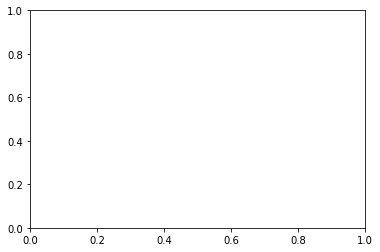

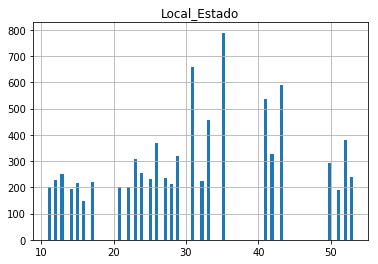

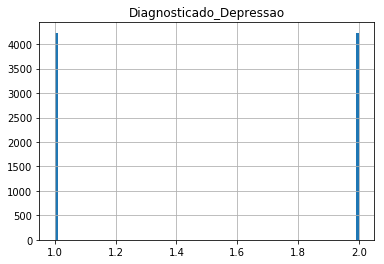

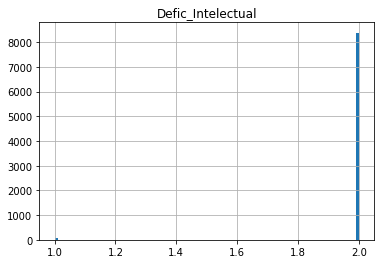

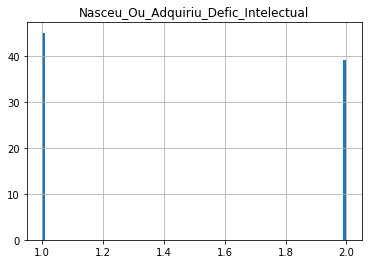

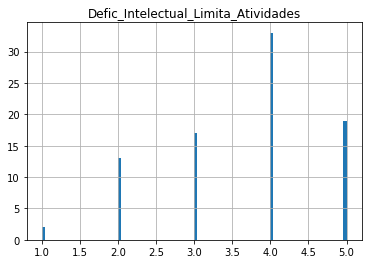

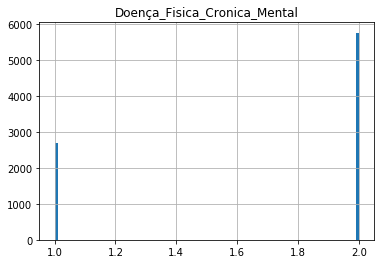

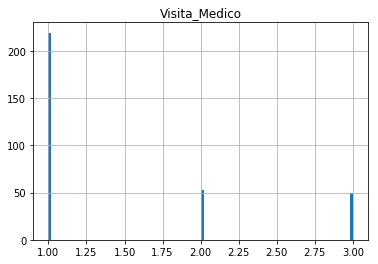

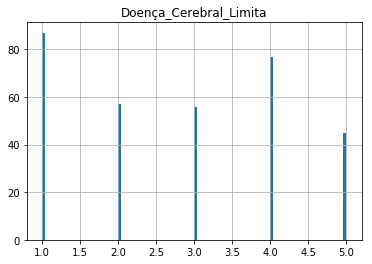

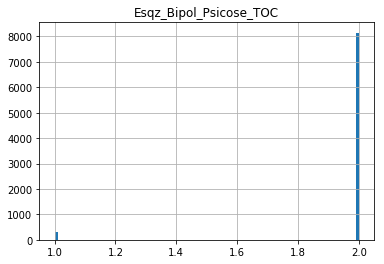

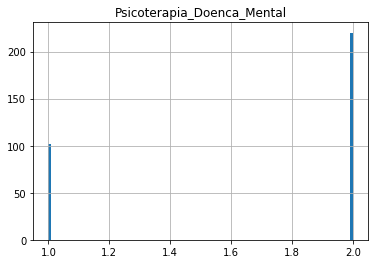

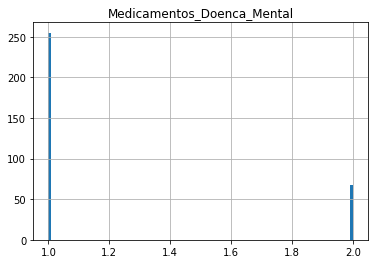

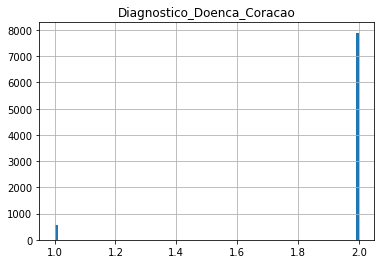

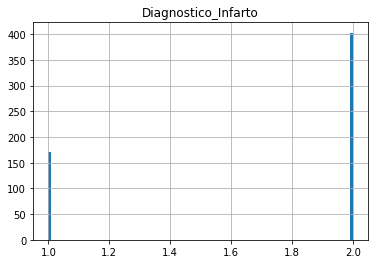

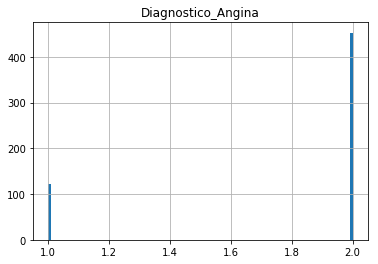

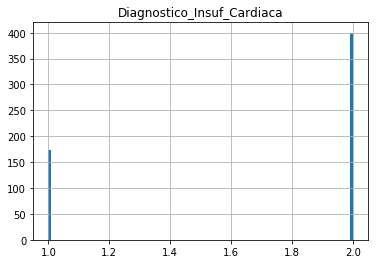

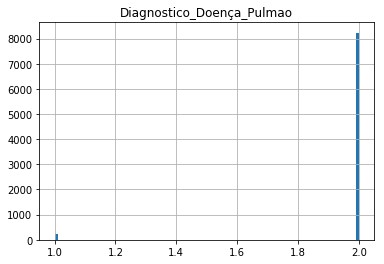

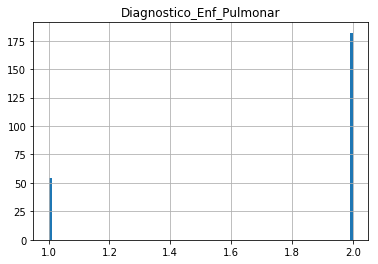

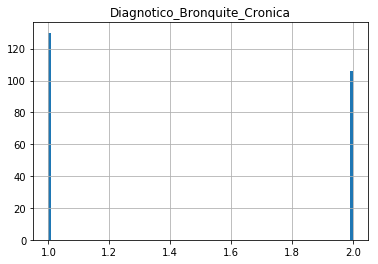

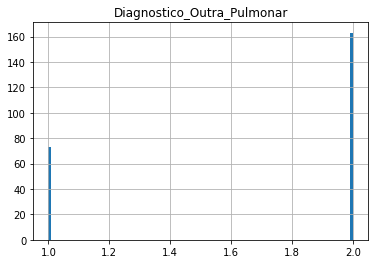

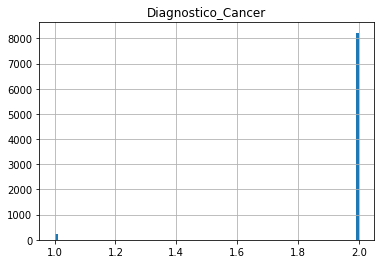

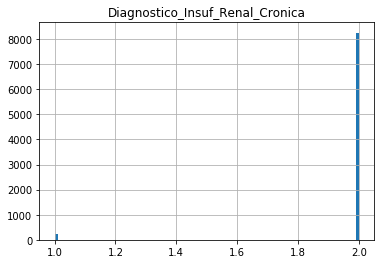

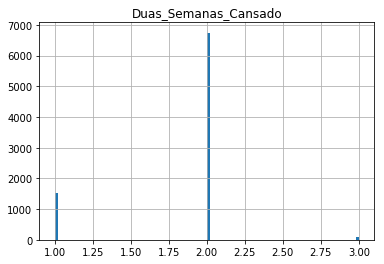

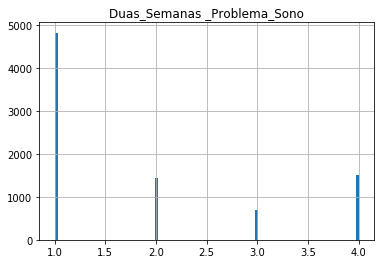

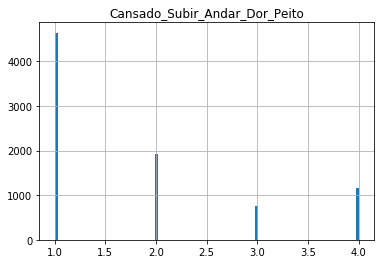

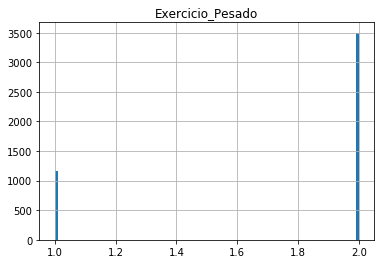

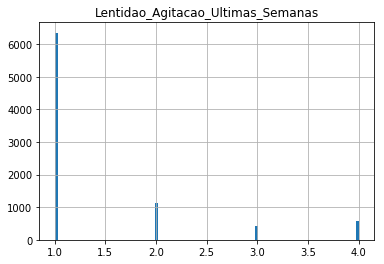

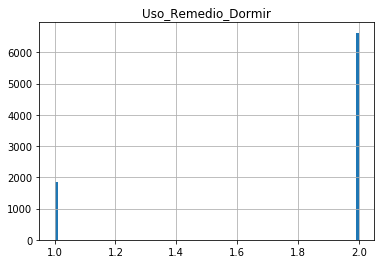

<Figure size 432x288 with 0 Axes>

In [47]:
path = '{}/figures'.format(module_path)

fig, ax = plt.subplots()

for col in list(df_sample):
    df_sample.hist(column=col, bins=100)
    fig.savefig('{}/{}.png'.format(path, col))

# Base com 1000 amostras aleatorias

In [ ]:
df_sampleNew = df_sample.sample(1000)

## Intervalo de Confiança

In [ ]:
z = 2.054 # 96%
s = df_sampleNew['Idade'].std()
m = df_sampleNew['Idade'].mean() 
n = df_sampleNew.shape[0]
p1 = m - (z * (s/math.sqrt(n)))
p2 = m + (z * (s/math.sqrt(n)))
print("{} < {} < {}".format(p1,m,p2))

## Poder Discriminativo de variáveis

In [ ]:
df_sample1 = df_sampleNew.loc[df_sampleNew['Diagnosticado_Depressao'] == 1]
s1 = df_sample1['Idade'].std()
m1 = df_sample1['Idade'].mean()
n1 = df_sample1['Idade'].count()

df_sample2 = df_sampleNew.loc[df_sampleNew['Diagnosticado_Depressao'] == 2]
s2 = df_sample2['Idade'].std()
m2 = df_sample2['Idade'].mean()
n2 = df_sample2['Idade'].count()

sa = math.pow(s1,2)/n1
sb = math.pow(s2,2)/n2

t = math.sqrt(sa + sb)
limiar = (m1 - m2)/t
##print("{} , {}, {} ||| {}, {}, {} ||| {}, {}, {} ".format(s1,m1,n1,s2,m2,n2,sa,sb,t))
print("Limiar : {} > {}".format(limiar,0.5))